# Transitivity of Models

In this lesson, we show that the importants of understanding the assumptions that a particular model makes about the data it is modeling.

Let's say you are going through the literature and find the following results:

### Task A

| Algorithm | Accuracy |
| --------- | -------- |
| A         | 0.75     |
| B         | 0.89     |

### Task B

| Algorithm | Accuracy |
| --------- | -------- |
| B         | 0.92     |
| C         | 0.97     |

What are your conclusions? What questions do you have? If your task was to solve Task A, Task B or a third Task C, do these results inform which algorithms you would pick?

In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

/home/micha/projects/acm_paper_2018/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pylab as py
import seaborn as sns

In [3]:
from keras import datasets
import pandas as pd

In [4]:
def run_experiment(model, X, y, **fit_params):
    return cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1, fit_params=fit_params)

def plot_scores(dataset, scores, names):
    py.boxplot(scores)
    py.title('{} on {} dataset'.format(" vs ".join(names), dataset))
    py.ylabel('Accuracy')
    py.xticks(np.arange(len(names))+1, names)
    
np.random.seed(4242)

## First, let's train logistic regression and an RFC on the IRIS dataset

In [5]:
print("Loading IRIS")
iris = pd.read_csv('./data/iris.csv', dtype={'species':'category'})
iris = iris.sample(frac=1).reset_index(drop=True)  # shuffle
iris_features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_target = 'species'
iris.head()

Loading IRIS


,sepal_length,sepal_width,petal_length,petal_width,species
0,4.6,3.4,1.4,0.3,setosa
1,7.7,3.0,6.1,2.3,virginica
2,6.4,2.7,5.3,1.9,virginica
3,6.4,2.9,4.3,1.3,versicolor
4,4.8,3.4,1.6,0.2,setosa


In [6]:
iris_X, iris_y = iris[iris_features].values, iris['species'].cat.codes.values

In [7]:
iris_logit = LogisticRegression()
iris_rfc = RandomForestClassifier(n_estimators=20)

In [8]:
iris_logit_scores = run_experiment(iris_logit, iris_X, iris_y)
iris_rfc_scores = run_experiment(iris_rfc, iris_X, iris_y)

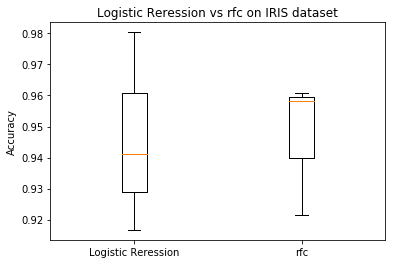

In [9]:
plot_scores("IRIS", [iris_logit_scores, iris_rfc_scores], ['Logistic Reression', 'rfc'])

We can see that on average, the random forest classifier does better than the logistic regression. Let's take that model and use it on the next dataset.

## Now let's train an rfc and a CNN on MNIST

In [10]:
print("Fetching MNIST")
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

mnist_X = np.vstack([x_train, x_test]) / 255
mnist_X = mnist_X.reshape((mnist_X.shape[0], -1))
mnist_y = np.concatenate([y_train, y_test])

random_idx = np.random.permutation(mnist_X.shape[0])
mnist_X = mnist_X[random_idx]
mnist_y = mnist_y[random_idx]

Fetching MNIST


In [11]:
def create_basic_cnn(n_features=784, n_classes=10):
    width = int(n_features**0.5)
    X_in = X = Input(shape=(n_features,))
    X = Reshape((width, width, 1))(X)
    X = Conv2D(8, kernel_size=(2, 2), activation='relu')(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(n_classes, activation='softmax')(X)
    model = Model(inputs=X_in, outputs=X)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
mnist_rfc = RandomForestClassifier()
mnist_cnn = KerasClassifier(
    create_basic_cnn,
    n_features=mnist_X.shape[-1],
    n_classes=10,
)

In [13]:
mnist_rfc_scores = run_experiment(mnist_rfc, mnist_X, mnist_y)
mnist_cnn_scores = run_experiment(mnist_cnn, mnist_X, mnist_y,
                                  epochs=20, callbacks=[EarlyStopping()],
                                  verbose=0, validation_split=0.1)

INFO (theano.gof.compilelock): Waiting for existing lock by process '15023' (I am process '15024')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/micha/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.6.5-64/lock_dir


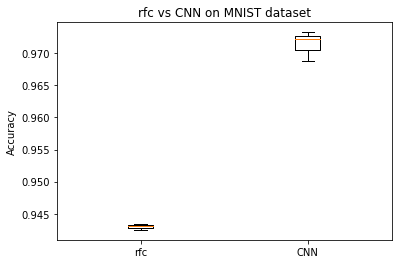

In [14]:
plot_scores("MNIST", [mnist_rfc_scores, mnist_cnn_scores], ['rfc', 'CNN'])

The CNN does drastically better than the random forest so it's easy to consider the CNN to be a better model. So is it better than the logistic regression?

## But how well does the CNN compared to Logistic Regression on the IRIS dataset?

In [15]:
iris_cnn = KerasClassifier(
    create_basic_cnn,
    n_features=iris_X.shape[-1],
    n_classes=3,
)

In [16]:
iris_cnn_scores = run_experiment(iris_cnn, iris_X, iris_y,
                                 epochs=20, callbacks=[EarlyStopping()],
                                 verbose=0, validation_split=0.1)

INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '16866')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/micha/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.6.5-64/lock_dir


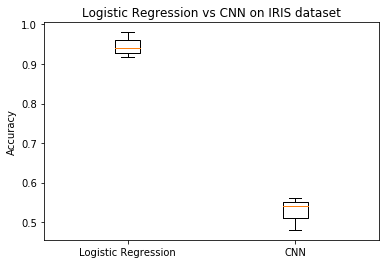

In [17]:
plot_scores("IRIS", [iris_logit_scores, iris_cnn_scores], ['Logistic Regression', 'CNN'])

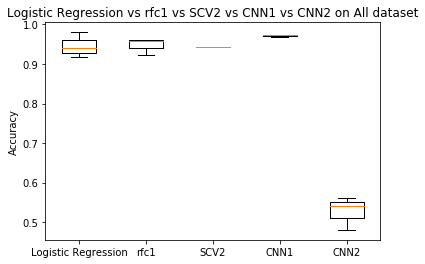

In [18]:
plot_scores("All",
            [iris_logit_scores, iris_rfc_scores, mnist_rfc_scores, mnist_cnn_scores, iris_cnn_scores],
            ['Logistic Regression', 'rfc1', 'SCV2', 'CNN1', 'CNN2'])

So we see that even though, just looking at results, logit < rfc < cnn we also have cnn < logit. This shows that a system's performance is just as dependant on the data itself as it is on the modeling technique. It's important to realize that when picking a model, we are making decisions about properties we believe the data to have. In this case, the CNN explicitly makes the assumption that the data has some 2 dimensional structure... something which simply doesn't hold for the IRIS data.

In this case the differences in accuracy were quite remarkable, however this effect is seen all the time in much more subtle ways. Looking at a wider range of example from the [scikit learn documentation](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) we see this conclusion even more starkly.

![](./data/classifier_comparison.png)

Here where we can also see the decision surface, it is also important to make determinations about the inferences being made by the model. Looking at the bottom row of results, multiple models achieve a 95% accuracy but they all make different conclusions about the regions in which we currently don't have data. Which one do you have more faith in for when that data comes in and what real world impacts do these decision surfaces have if these models were being used in a real situation?